In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/server-logs-suspicious/CIDDS-001-external-week1.csv


In [2]:
df = pd.read_csv('/kaggle/input/server-logs-suspicious/CIDDS-001-external-week1.csv')

df.head()

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
0,2017-03-14 17:43:57.172,81412.697,TCP,EXT_SERVER,8082,OPENSTACK_NET,56978.0,3057,2.1 M,1,.AP...,0,normal,---,---,---
1,2017-03-14 17:43:57.172,81412.697,TCP,OPENSTACK_NET,56978,EXT_SERVER,8082.0,4748,2.5 M,1,.AP...,0,normal,---,---,---
2,2017-03-14 17:43:26.135,81504.787,TCP,EXT_SERVER,8082,OPENSTACK_NET,56979.0,8639,9.1 M,1,.AP...,0,normal,---,---,---
3,2017-03-14 17:43:26.135,81504.787,TCP,OPENSTACK_NET,56979,EXT_SERVER,8082.0,12024,10.3 M,1,.AP...,0,normal,---,---,---
4,2017-03-14 18:17:09.005,82100.692,TCP,EXT_SERVER,8082,OPENSTACK_NET,51649.0,11012,27.2 M,1,.AP.S.,0,normal,---,---,---


# Exploratory Data Analysis

In [3]:
# making all the column names one word
df.columns = df.columns.str.replace(' ', '_')

**Changing the data type of Date_first_seen from strings (object) to datetime**

First we convert the dtype of the column to datetime if it isn't datetime already
Then extract all the needed features

In [4]:
df['Date_first_seen'].head()

0    2017-03-14 17:43:57.172
1    2017-03-14 17:43:57.172
2    2017-03-14 17:43:26.135
3    2017-03-14 17:43:26.135
4    2017-03-14 18:17:09.005
Name: Date_first_seen, dtype: object

In [5]:
# changing the type of the Date_first_seen column from object to datetime and ensuring there is no null value
df['Date_first_seen'] = pd.to_datetime(df.Date_first_seen)

assert df.Date_first_seen.isnull().sum() == 0, 'missing Date_first_seen dates'

df['Date_first_seen'].head()

0   2017-03-14 17:43:57.172
1   2017-03-14 17:43:57.172
2   2017-03-14 17:43:26.135
3   2017-03-14 17:43:26.135
4   2017-03-14 18:17:09.005
Name: Date_first_seen, dtype: datetime64[ns]

Since all these activities happened within few days in same month and year,
we will extract the day and hours as a column. We will not be extracting the minutes and seconds.

In [6]:
df['day_of_activity'] = df['Date_first_seen'].dt.day

df['hours'] = df['Date_first_seen'].dt.hour

# drop the last 3 columns as they do not contain any value. Also the Tos and Flows as they contain only 1 value
# we will also drop the Date_first_seen column as we have extracted the data we need from it
df.drop(['Flows', 'Tos', 'attackType', 'attackID', 'attackDescription', 'Date_first_seen'], inplace=True, axis=1)

Modifying the Source and Destination IP to the specific categories we want

In [7]:
# we are going to maintain the values of Src_IP_Addr and Dst_IP_Addr to EXT_SERVER, OPENSTACK_NET and Other
# so we will be replacing all other values not EXT_SERVER and OPENSTACK_NET to Other

df['Src_IP_Addr'] = df['Src_IP_Addr'].apply(lambda x: 'Other' if x not in ['EXT_SERVER', 'OPENSTACK_NET'] else x)

df['Dst_IP_Addr'] = df['Dst_IP_Addr'].apply(lambda x: 'Other' if x not in ['EXT_SERVER', 'OPENSTACK_NET'] else x)


print(df['Src_IP_Addr'].unique(),
      df['Dst_IP_Addr'].unique())

['EXT_SERVER' 'OPENSTACK_NET' 'Other'] ['OPENSTACK_NET' 'EXT_SERVER' 'Other']


Source and desitnation ports, though numerical values, are actually categorical. This is because they take on one of a limited, and usually fixed, number of possible values of network ports. However, they cannot be encoded like that as they have over 1000 possible values.

We will therefore break it down to 2 columns. The first column will tell if the port is system port (0 - 1023), user port (1024 - 49151) and dynamic port (49152 - 65535).
The second column will tell us which protocol is the port assigned to and how standardised it is to that protocol

In [8]:
df['src_port_type'] = df['Src_Pt'].apply(lambda x: 'System port' if x in range(1023) else 'User port' if x in range(1024, 49151) else 'Dynamic port')
df['dst_port_type'] = df['Dst_Pt'].apply(lambda x: 'System port' if x in range(1023) else 'User port' if x in range(1024, 49151) else 'Dynamic port')


In [9]:
# partitioning the ports into their several accepted protocols

y_and_y = [7, 9, 11, 13, 17, 18, 19, 37, 49, 53, 71, 72, 73, 74, 80, 88, 104, 105, 107, 108, 111, 117, 118, 126, 135, 137, 152, 153, 156, 158, 162, 170, 177, 194, 199, 201, 210, 213, 218, 220, 259, 262, 264, 280, 318, 350, 351, 356, 366, 369, 370, 371, 376, 383, 384, 387, 399, 401, 427, 433, 434, 443, 444, 445, 464, 475, 497, 502, 504, 510, 524, 530, 542, 546, 547, 550, 554, 563, 593, 631, 635, 639, 641, 643, 646, 651, 653, 655, 657, 666, 688, 690, 694, 749, 753, 754, 800, 802, 830, 831, 832, 833, 848, 853, 861, 862, 989, 990, 991, 992, 995, 1058, 1059, 1080, 1085, 1098, 1119, 1167, 1194, 1198, 1214, 1234, 1270, 1293, 1311, 1319, 1337, 1341, 1344, 1352, 1360, 1414, 1417, 1418, 1419, 1420, 1433, 1434, 1481, 1512, 1521, 1524, 1527, 1533, 1547, 1581, 1589, 1628, 1629, 1677, 1701, 1707, 1719, 1720, 1755, 1801, 1812, 1813, 1863, 1883, 1935, 1970, 1972, 1984, 1998, 2000, 2049, 2080, 2083, 2086, 2102, 2103, 2104, 2123, 2142, 2152, 2159, 2181, 2210, 2211, 2222, 2240, 2261, 2262, 2399, 2401, 2404, 2427, 2447, 2459, 2483, 2484, 2535, 2541, 2546, 2547, 2548, 2628, 2638, 2727, 2775, 2809, 2811, 2944, 2945, 2947, 2948, 2949, 2967, 3020, 3050, 3052, 3074, 3225, 3233, 3260, 3268, 3269, 3283, 3305, 3386, 3389, 3396, 3412, 3455, 3478, 3493, 3503, 3516, 3551, 3645, 3659, 3667, 3690, 3702, 3724, 3725, 3749, 3768, 3804, 3826, 3830, 3880, 3999, 4018, 4089, 4090, 4093, 4096, 4105, 4116, 4172, 4303, 4486, 4662, 4730, 4739, 4753, 4840, 4843, 4847, 4894, 4950, 5004, 5005, 5010, 5011, 5025, 5060, 5062, 5064, 5084, 5085, 5099, 5150, 5154, 5190, 5298, 5349, 5355, 5402, 5405, 5412, 5413, 5417, 5421, 5556, 5568, 5683, 5684, 5722, 5741, 5742, 5900, 5931, 5984, 6110, 6111, 6112, 6346, 6347, 6350, 6444, 6445, 6464, 6515, 6619, 6622, 6679, 6801, 6888, 6924, 6969, 7262, 7272, 7400, 7401, 7402, 7542, 7547, 7624, 8074, 8080, 8194, 8195, 8243, 8280, 8883, 9001, 9080, 9101, 9102, 9103, 9119, 9389, 9418, 9535, 9536, 9800, 10000, 10050, 10051, 10110, 11001, 11112, 11235, 11371, 13400, 13720, 13721, 13724, 13782, 13783, 13785, 13786, 15345, 17224, 17225, 17500, 19813, 24465, 24554, 26000, 27000, 27001, 27002, 27003, 27004, 27005, 27006, 27007, 27008, 27009, 28000, 33434, 40000, 41121, 41794, 41795, 44818]
y_and_n = [113, 308, 465, 512, 513, 520, 540, 543, 544, 556, 591, 601, 604, 647, 648, 654, 674, 691, 695, 700, 701, 702, 706, 711, 712, 847, 860, 873, 1431, 1776, 2095, 2223, 2224, 2225, 2226, 3423, 3424, 3601, 3868, 3872, 3900, 4190, 4307, 4321, 4604, 4605, 4728, 4949, 5044, 5048, 5051, 5061, 5151, 5172, 5228, 5269, 5280, 5631, 5670, 5985, 5986, 6086, 6159, 6379, 6432, 6513, 6514, 6566, 6600, 6601, 6602, 6665, 6666, 6667, 6668, 6669, 6697, 7473, 7474, 7478, 7631, 7687, 8007, 8118, 8123, 8140, 8400, 8401, 8403, 8880, 9306, 9312, 9695, 10212, 10933, 13075, 17472, 18104, 19812, 19814, 19999, 20000, 31457, 32400, 35357, 41796, 41797]
y_and_a = [1, 20, 21, 22, 23, 25, 43, 70, 79, 83, 95, 101, 102, 109, 110, 115, 119, 139, 143, 179, 209, 311, 388, 389, 515, 532, 548, 587, 636, 660, 829, 993, 1099, 1220, 1723, 3306, 3632, 3689, 4111, 4488, 5003, 5432, 5671, 5672, 6653, 9100]
y_and_r = [953, 2375, 2376, 2377, 2379, 2380, 5222, 5318]
n_and_y = [319, 320, 517, 518, 521, 525, 533, 560, 561, 623, 698, 750, 3483, 3527, 3544, 3784, 3799, 4069, 4569, 4789, 4791, 5093, 5246, 5247, 5632, 6343, 7023, 9899, 12222, 12223]
n_and_n = [585]
n_and_u = [82, 752, 987, 1534, 1645, 1646, 1716, 1967, 2302, 2303, 2305, 2501, 3290, 3332, 3785, 3960, 3962, 4534, 4672, 4944, 5029, 5198, 5199, 5394, 5445, 5499, 6257, 6771, 7312, 7575, 7655, 7717, 7979, 8116, 8303, 8767, 9296, 9303, 9600, 9897, 9993, 10001, 10505, 10823, 11100, 12012, 12035, 12307, 12308, 14550, 14567, 15567, 16384, 16567, 19132, 19133, 19295, 19302, 20582, 20583, 20595, 20808, 25575, 25826, 26822, 27015, 27888, 27950, 28015, 28016, 30000, 33848, 34000, 34197, 37008]
a_and_y = [42, 67, 68, 69, 123, 138, 161, 500, 1113, 1900, 1985, 4500, 5065, 5310, 5353]
a_and_a = [5, 52, 54, 56, 58, 2389, 6201]
u_and_n = [15, 28, 81, 300, 491, 514, 564, 625, 782, 783, 808, 843, 888, 903, 981, 1010, 1029, 1314, 1492, 1500, 1501, 1583, 1626, 1627, 1666, 1688, 1880, 1965, 2010, 2082, 2087, 2096, 2100, 2101, 2195, 2196, 2221, 2351, 2368, 2369, 2370, 2372, 2424, 2480, 2598, 2827, 3000, 3004, 3101, 3128, 3333, 3351, 3535, 3825, 3835, 4001, 4035, 4050, 4125, 4201, 4222, 4242, 4243, 4445, 4560, 4567, 4664, 4711, 4713, 4747, 4848, 5000, 5001, 5002, 5007, 5037, 5050, 5070, 5104, 5121, 5200, 5223, 5281, 5433, 5457, 5458, 5480, 5481, 5495, 5498, 5500, 5501, 5517, 5550, 5601, 5656, 5666, 5667, 5693, 5701, 5718, 5719, 5723, 5724, 5800, 5905, 6005, 6009, 6050, 6051, 6100, 6101, 6113, 6136, 6200, 6225, 6227, 6240, 6262, 6389, 6436, 6437, 6516, 6543, 6556, 6571, 6660, 6661, 6662, 6663, 6664, 6690, 6699, 6715, 6783, 6784, 6785, 7000, 7001, 7002, 7005, 7006, 7010, 7022, 7025, 7047, 7133, 7144, 7145, 7171, 7306, 7307, 7396, 7471, 7634, 7652, 7653, 7654, 7656, 7657, 7658, 7659, 7660, 7670, 7680, 7777, 7831, 7890, 7915, 7935, 7990, 8000, 8005, 8006, 8009, 8010, 8042, 8069, 8070, 8075, 8088, 8089, 8090, 8091, 8092, 8096, 8111, 8112, 8124, 8125, 8139, 8172, 8184, 8200, 8222, 8245, 8281, 8291, 8332, 8333, 8334, 8337, 8384, 8388, 8443, 8444, 8448, 8484, 8500, 8530, 8531, 8555, 8580, 8629, 8642, 8691, 8765, 8834, 8840, 8887, 8888, 8889, 8920, 8983, 8997, 8998, 8999, 9000, 9002, 9030, 9042, 9043, 9050, 9051, 9060, 9081, 9090, 9091, 9092, 9150, 9191, 9199, 9200, 9217, 9293, 9300, 9332, 9333, 9339, 9392, 9419, 9420, 9421, 9422, 9425, 9443, 9669, 9875, 9898, 9901, 9981, 9982, 9987, 9997, 10011, 10024, 10025, 10042, 10172, 10200, 10308, 10480, 10800, 10891, 11111, 11753, 12043, 12046, 12443, 12489, 12975, 14800, 15000, 15441, 15672, 16000, 16080, 16200, 16225, 16250, 16300, 16400, 17011, 17333, 17475, 18080, 18081, 18333, 19226, 19294, 19531, 19532, 21025, 21064, 22000, 22136, 22222, 23073, 23399, 23513, 24444, 24800, 24842, 25565, 27016, 27017, 27374, 28001, 28260, 28443, 28769, 28770, 29000, 30033, 30120, 30564, 31337, 31416, 31438, 32764, 32887, 32976, 36330, 43110, 44405, 49160, 49190]
u_and_u = [90, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 751, 760, 897, 898, 902, 1241, 1494, 1503, 1513, 1540, 1541, 1542, 1545, 1550, 1604, 1761, 2033, 2056, 2500, 2593, 2599, 2710, 3323, 3479, 3480, 3856, 3979, 4000, 4045, 4070, 4198, 4226, 4244, 4444, 5031, 5090, 5124, 5125, 5201, 5242, 5243, 5357, 5358, 5450, 5554, 5555, 5938, 6244, 6255, 6260, 6502, 6881, 6882, 6883, 6884, 6885, 6886, 6887, 6889, 6890, 6891, 6892, 6893, 6894, 6895, 6896, 6897, 6898, 6899, 6900, 6901, 7070, 7880, 7946, 8008, 9295, 9309, 9675, 9676, 9785, 9999, 10009, 10514, 11211, 11214, 11215, 11311, 12000, 12013, 12201, 12345, 13008, 15009, 15010, 16261, 16666, 16677, 17777, 18091, 18092, 18200, 18201, 18206, 18300, 18301, 18306, 18400, 18401, 18505, 18506, 18605, 18606, 18676, 19000, 19001, 19150, 20560, 24441, 27036, 28852, 28910, 28960, 29070, 29900, 29901, 29920, 32137, 64738]
r_and_y = [5351]
r_and_n = [1027, 1028, 1783, 9006]
r_and_r = [47, 51, 61, 250, 251, 252, 253, 254, 255, 994, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1023, 1024, 1109, 49151]

def port_assignment(port_list):
    label_list = []
    for port in port_list:
        if port in y_and_y:
            label_list.append('TCP and UDP assigned and standardized port')
        elif port in y_and_n:
            label_list.append('TCP assigned and standardized port only')
        elif port in y_and_a:
            label_list.append('TCP assigned and standardized, UDP assinged only port')
        elif port in y_and_r:
            label_list.append('TCP assigned and standardized, UDP reserved only port')
        elif port in n_and_y:
            label_list.append('UDP assigned and standardized port only')
        elif port in n_and_n:
            label_list.append('Not assigned nor standardized port for any protocol')
        elif port in n_and_u:
            label_list.append('UDP standardized but not assigned port')
        elif port in a_and_y:
            label_list.append('TCP assigned only, UDP assigned and standardized port')
        elif port in a_and_a:
            label_list.append('TCP and UDP assigned but not standardized port')
        elif port in u_and_n:
            label_list.append('TCP not assigned but standardized port only')
        elif port in u_and_u:
            label_list.append('TCP and UDP standardized but not assigned port')
        elif port in r_and_y:
            label_list.append('TCP reserved, UDP assigned and standardized port')
        elif port in r_and_n:
            label_list.append('TCP reserved port only')
        elif port in r_and_r:
            label_list.append('TCP and UDP reserved port')
        else:
            label_list.append('Private unofficial port')
    return label_list

In [10]:
df.loc[:, 'Src_port_cat'] = port_assignment(df['Src_Pt'])
df.loc[:, 'Dst_port_cat'] = port_assignment(df['Dst_Pt'])

In [11]:
df.drop(['Src_Pt', 'Dst_Pt'], inplace=True, axis=1)

Making sure the Bytes are in uniform measure. Hence converting the MBs (MegaBytes) to Bytes

In [12]:
import re as re
def find_number(data):
    if 'M' in data['Bytes']:
        num_str = re.findall(r'\d*\.?\d+',data['Bytes'])
        num = float(" ".join(num_str)) * 100000
        return num
    else:
        num_str = re.findall(r'\d*\.?\d+',data['Bytes'])
        num = float(" ".join(num_str))
        return num
    
df['Bytes']=df.apply(find_number, axis=1)

In [13]:
df.head(20)

,Duration,Proto,Src_IP_Addr,Dst_IP_Addr,Packets,Bytes,Flags,class,day_of_activity,hours,src_port_type,dst_port_type,Src_port_cat,Dst_port_cat
0,81412.697,TCP,EXT_SERVER,OPENSTACK_NET,3057,210000.0,.AP...,normal,14,17,User port,Dynamic port,Private unofficial port,Private unofficial port
1,81412.697,TCP,OPENSTACK_NET,EXT_SERVER,4748,250000.0,.AP...,normal,14,17,Dynamic port,User port,Private unofficial port,Private unofficial port
2,81504.787,TCP,EXT_SERVER,OPENSTACK_NET,8639,910000.0,.AP...,normal,14,17,User port,Dynamic port,Private unofficial port,Private unofficial port
3,81504.787,TCP,OPENSTACK_NET,EXT_SERVER,12024,1030000.0,.AP...,normal,14,17,Dynamic port,User port,Private unofficial port,Private unofficial port
4,82100.692,TCP,EXT_SERVER,OPENSTACK_NET,11012,2720000.0,.AP.S.,normal,14,18,User port,Dynamic port,Private unofficial port,Private unofficial port
5,82100.692,TCP,OPENSTACK_NET,EXT_SERVER,14186,120000.0,.AP.S.,normal,14,18,Dynamic port,User port,Private unofficial port,Private unofficial port
6,83640.139,TCP,EXT_SERVER,OPENSTACK_NET,9974,3190000.0,.AP.S.,normal,14,19,User port,User port,Private unofficial port,Private unofficial port
7,83640.139,TCP,OPENSTACK_NET,EXT_SERVER,16476,170000.0,.AP.S.,normal,14,19,User port,User port,Private unofficial port,Private unofficial port
8,86303.297,TCP,EXT_SERVER,OPENSTACK_NET,10178,2520000.0,.AP.S.,normal,14,19,User port,User port,Private unofficial port,Private unofficial port
9,86303.297,TCP,OPENSTACK_NET,EXT_SERVER,14552,260000.0,.AP.S.,normal,14,19,User port,User port,Private unofficial port,Private unofficial port


**Handling Flags**

Flags in network connection are used to indicate a particular state of connection or to provide some additional useful information like troubleshooting purposes or to handle a control of a particular connection. However whenever a certain flag is not set, a dot (.) is used to indicate that. Therefore we need to break down the flags columns into its various flagpoints to help the model understand when a flag is seen and what type of flag.

In [14]:
df['Flags'].unique()

array(['.AP...', '.AP.S.', '....S.', '.A.R..', '.APRS.', '.APRSF',
       '.AP.SF', '......', '  0xdb', '...RS.', '.A..S.', '.A..SF',
       '.A.RS.', '.A.RSF', '...R..', '.A....', '  0xd2', '.A.R.F',
       '  0xc2', '  0xda', '  0xd7', '  0x53', '  0xdf', '  0xd6',
       '  0xd3'], dtype=object)

In [15]:
# creating the needed columns for each flag type

df["A"]=0
df["P"]=0
df["S"]=0
df["R"]=0
df["F"]=0
df["X"]=0

In [16]:
def set_flag(data,check):
    val=0;
    if(check in list(data["Flags"])):
        val = 1 ;
    return val;

In [17]:
df["A"] = df.apply(set_flag,check ="A", axis = 1)
df["P"] = df.apply(set_flag,check = "P" ,axis = 1)
df["S"] = df.apply(set_flag,check ="S",axis = 1)
df["R"] = df.apply(set_flag,check="R" ,axis = 1)
df["F"] = df.apply(set_flag,check ="F" ,axis = 1)
df["X"] = df.apply(set_flag,check ="x" ,axis = 1)

In [18]:
df.drop(['Flags'], inplace=True, axis=1)

In [19]:
df.head()

,Duration,Proto,Src_IP_Addr,Dst_IP_Addr,Packets,Bytes,class,day_of_activity,hours,src_port_type,dst_port_type,Src_port_cat,Dst_port_cat,A,P,S,R,F,X
0,81412.697,TCP,EXT_SERVER,OPENSTACK_NET,3057,210000.0,normal,14,17,User port,Dynamic port,Private unofficial port,Private unofficial port,1,1,0,0,0,0
1,81412.697,TCP,OPENSTACK_NET,EXT_SERVER,4748,250000.0,normal,14,17,Dynamic port,User port,Private unofficial port,Private unofficial port,1,1,0,0,0,0
2,81504.787,TCP,EXT_SERVER,OPENSTACK_NET,8639,910000.0,normal,14,17,User port,Dynamic port,Private unofficial port,Private unofficial port,1,1,0,0,0,0
3,81504.787,TCP,OPENSTACK_NET,EXT_SERVER,12024,1030000.0,normal,14,17,Dynamic port,User port,Private unofficial port,Private unofficial port,1,1,0,0,0,0
4,82100.692,TCP,EXT_SERVER,OPENSTACK_NET,11012,2720000.0,normal,14,18,User port,Dynamic port,Private unofficial port,Private unofficial port,1,1,1,0,0,0


In [20]:
df['X'].unique()

array([0, 1])

**Now check for any null value**

In [21]:
df.isnull().sum()

Duration           0
Proto              0
Src_IP_Addr        0
Dst_IP_Addr        0
Packets            0
Bytes              0
class              0
day_of_activity    0
hours              0
src_port_type      0
dst_port_type      0
Src_port_cat       0
Dst_port_cat       0
A                  0
P                  0
S                  0
R                  0
F                  0
X                  0
dtype: int64

We do not have any null value

Seem most of our data has white spaces, we will loop though and remove all white spaces

In [22]:
cat_cols = df.dtypes[(df.dtypes == 'object')].index.tolist()
for col in cat_cols:
    df[col].str.strip()

In [23]:
data = df.copy()
data.shape

(172838, 19)

****Exploring the cleaned data****

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172838 entries, 0 to 172837
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Duration         172838 non-null  float64
 1   Proto            172838 non-null  object 
 2   Src_IP_Addr      172838 non-null  object 
 3   Dst_IP_Addr      172838 non-null  object 
 4   Packets          172838 non-null  int64  
 5   Bytes            172838 non-null  float64
 6   class            172838 non-null  object 
 7   day_of_activity  172838 non-null  int64  
 8   hours            172838 non-null  int64  
 9   src_port_type    172838 non-null  object 
 10  dst_port_type    172838 non-null  object 
 11  Src_port_cat     172838 non-null  object 
 12  Dst_port_cat     172838 non-null  object 
 13  A                172838 non-null  int64  
 14  P                172838 non-null  int64  
 15  S                172838 non-null  int64  
 16  R                172838 non-null  int6

In [25]:
data.describe()

,Duration,Packets,Bytes,day_of_activity,hours,A,P,S,R,F,X
count,172838.000000,172838.000000,1.728380e+05,172838.000000,172838.000000,172838.000000,172838.000000,172838.000000,172838.000000,172838.000000,172838.000000
mean,136.290559,13.809799,1.879891e+03,18.166404,11.951978,0.855234,0.727138,0.907231,0.180603,0.691445,0.004143
std,5215.645494,232.725151,3.109940e+04,1.985452,7.023066,0.351865,0.445432,0.290109,0.384690,0.461898,0.064230
min,0.000000,1.000000,2.800000e+01,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.057000,5.000000,2.640000e+02,16.000000,6.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,5.930000,7.000000,5.890000e+02,18.000000,12.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,16.848250,17.000000,2.430000e+03,20.000000,18.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,519611.231000,34136.000000,6.480000e+06,21.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Drop rows with Duration = 0**

In [26]:
data = data.set_index('Duration')
data = data.drop(0.0, axis=0)
data.reset_index(inplace=True)

In [27]:
data.head()

,Duration,Proto,Src_IP_Addr,Dst_IP_Addr,Packets,Bytes,class,day_of_activity,hours,src_port_type,dst_port_type,Src_port_cat,Dst_port_cat,A,P,S,R,F,X
0,81412.697,TCP,EXT_SERVER,OPENSTACK_NET,3057,210000.0,normal,14,17,User port,Dynamic port,Private unofficial port,Private unofficial port,1,1,0,0,0,0
1,81412.697,TCP,OPENSTACK_NET,EXT_SERVER,4748,250000.0,normal,14,17,Dynamic port,User port,Private unofficial port,Private unofficial port,1,1,0,0,0,0
2,81504.787,TCP,EXT_SERVER,OPENSTACK_NET,8639,910000.0,normal,14,17,User port,Dynamic port,Private unofficial port,Private unofficial port,1,1,0,0,0,0
3,81504.787,TCP,OPENSTACK_NET,EXT_SERVER,12024,1030000.0,normal,14,17,Dynamic port,User port,Private unofficial port,Private unofficial port,1,1,0,0,0,0
4,82100.692,TCP,EXT_SERVER,OPENSTACK_NET,11012,2720000.0,normal,14,18,User port,Dynamic port,Private unofficial port,Private unofficial port,1,1,1,0,0,0


In [28]:
cat_cols = ['Proto', 'Src_IP_Addr', 'Dst_IP_Addr', 'day_of_activity', 'hours', 'src_port_type', 'dst_port_type', 'Src_port_cat', 'Dst_port_cat', 'A', 'P', 'S', 'R', 'F', 'X']
num_cols = ['Duration', 'Packets', 'Bytes']
str_cat_cols = ['Proto', 'Src_IP_Addr', 'Dst_IP_Addr', 'src_port_type', 'dst_port_type', 'Src_port_cat', 'Dst_port_cat']

In [29]:
data['class'].unique()

array(['normal', 'suspicious', 'unknown'], dtype=object)

<AxesSubplot:xlabel='class', ylabel='count'>

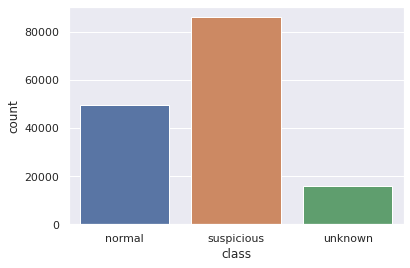

In [30]:
sns.set(style = 'darkgrid')
sns.countplot(x = 'class', data=data)

We can see majority of our data (more than half) is of the Suspecious class.

Let us check the individual flags and other columns and see their impacts on the class label

<AxesSubplot:xlabel='F', ylabel='count'>

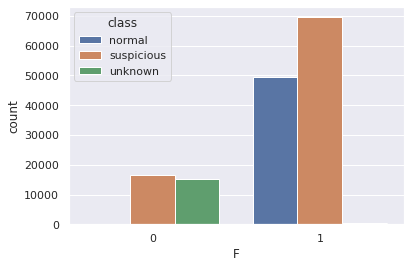

In [31]:
flags = ["A", "P", "S", "R", "F", "X"]
sns.countplot(x = flags[-2], hue = 'class', data = data)  # keep changing the flags to see their seperate impacts on the class

<AxesSubplot:xlabel='src_port_type', ylabel='count'>

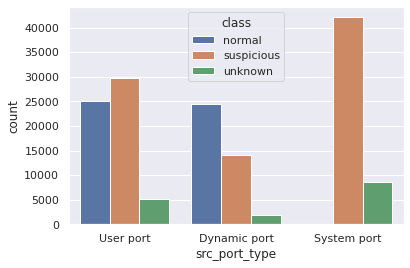

In [32]:
sns.countplot(x = "src_port_type", hue = "class",data = data)

We can see TCP is responsible for almost all the suspecious class. It is also responsible for all the normal and unknown class

# Feature Engineering

Label encoding the categorical data 

In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [34]:
data1 = data.copy()
data1['class'] = le.fit_transform(data1['class'])

le.classes_

array(['normal', 'suspicious', 'unknown'], dtype=object)

In [35]:
for col in str_cat_cols:
    data1[col] = le.fit_transform(data1[col])

In [36]:
data1.head()

,Duration,Proto,Src_IP_Addr,Dst_IP_Addr,Packets,Bytes,class,day_of_activity,hours,src_port_type,dst_port_type,Src_port_cat,Dst_port_cat,A,P,S,R,F,X
0,81412.697,1,0,1,3057,210000.0,0,14,17,2,0,0,0,1,1,0,0,0,0
1,81412.697,1,1,0,4748,250000.0,0,14,17,0,2,0,0,1,1,0,0,0,0
2,81504.787,1,0,1,8639,910000.0,0,14,17,2,0,0,0,1,1,0,0,0,0
3,81504.787,1,1,0,12024,1030000.0,0,14,17,0,2,0,0,1,1,0,0,0,0
4,82100.692,1,0,1,11012,2720000.0,0,14,18,2,0,0,0,1,1,1,0,0,0


<AxesSubplot:>

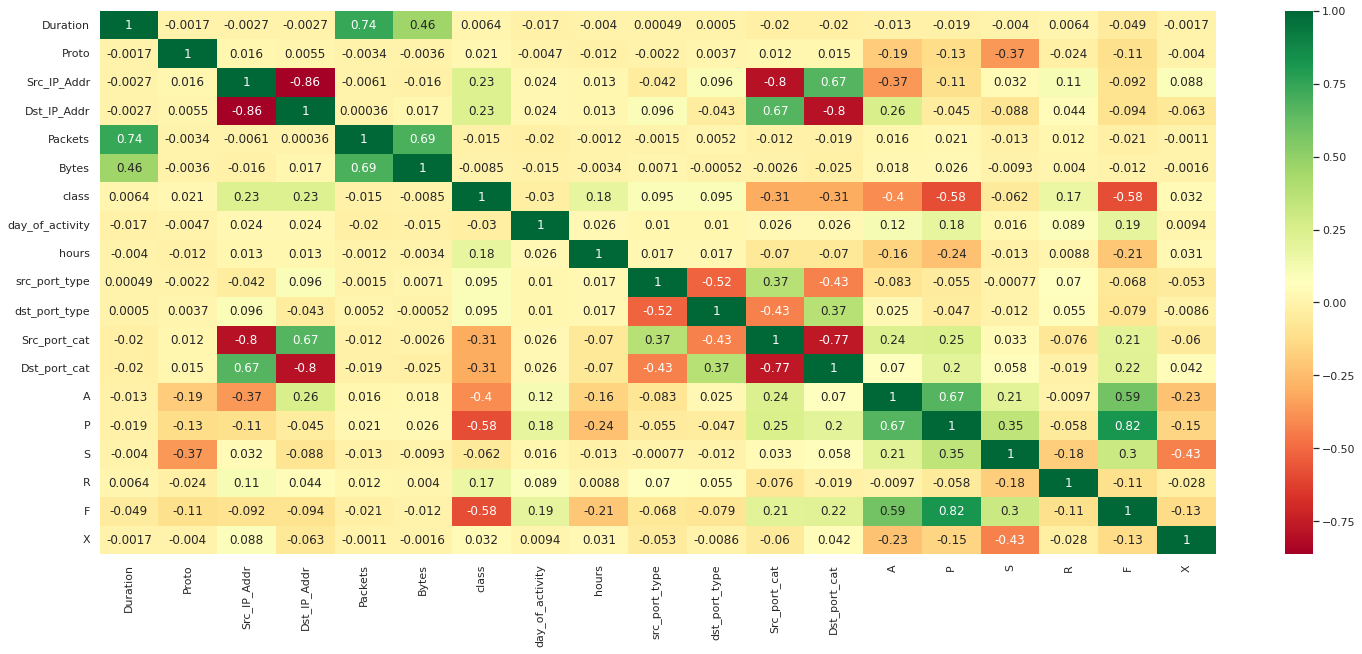

In [37]:
# let us see and analyse the correlation heatmap

plt.figure(figsize=(25,10))
sns.heatmap(data1.corr(), annot=True, cmap='RdYlGn')

**Next we will one-hot-encode all categorical data, split and then scale the dataset**

In [38]:
from sklearn.preprocessing import OneHotEncoder
le2 = LabelEncoder()
ohe = OneHotEncoder()

In [39]:
for col in cat_cols:
    dt_label = le2.fit_transform(data[col]).astype(np.int)
    dt_ohe = ohe.fit_transform(dt_label.reshape(-1,1)).astype(np.int)
    data = data.drop(col, axis=1)
    
    n_cols = dt_ohe.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]
    
    new_df = pd.DataFrame(dt_ohe.toarray(),
                          index=data.index, 
                          columns=col_names)
    data = pd.concat([data, new_df], axis=1)

In [40]:
data.head()

,Duration,Packets,Bytes,class,Proto_0,Proto_1,Proto_2,Src_IP_Addr_0,Src_IP_Addr_1,Src_IP_Addr_2,...,P_0,P_1,S_0,S_1,R_0,R_1,F_0,F_1,X_0,X_1
0,81412.697,3057,210000.0,normal,0,1,0,1,0,0,...,0,1,1,0,1,0,1,0,1,0
1,81412.697,4748,250000.0,normal,0,1,0,0,1,0,...,0,1,1,0,1,0,1,0,1,0
2,81504.787,8639,910000.0,normal,0,1,0,1,0,0,...,0,1,1,0,1,0,1,0,1,0
3,81504.787,12024,1030000.0,normal,0,1,0,0,1,0,...,0,1,1,0,1,0,1,0,1,0
4,82100.692,11012,2720000.0,normal,0,1,0,1,0,0,...,0,1,0,1,1,0,1,0,1,0


**Splitting the dataset**

In [41]:
# We already know our data class is skewed torwards the suspecious. 
# We will be spliting the dataset using stratefied splitting to cover for the skewness

data['class'].value_counts()

suspicious    86043
normal        49606
unknown       15742
Name: class, dtype: int64

In [42]:
data['class'].value_counts(normalize=True)

suspicious    0.568350
normal        0.327668
unknown       0.103982
Name: class, dtype: float64

In [43]:
data['class'] = le2.fit_transform(data['class']).astype(np.int)
data['class'].head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

In [44]:
# Let us split the data with the suspecious class being stratefied

from sklearn.model_selection import StratifiedShuffleSplit

feat_cols = [x for x in data.columns if x != 'class']

In [45]:
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

train_idx, test_idx = next(ss_split.split(data[feat_cols], data['class']))

X_train = data.loc[train_idx, feat_cols]
y_train = data.loc[train_idx, 'class']

X_test = data.loc[test_idx, feat_cols]
y_test = data.loc[test_idx, 'class']

In [46]:
y_train.value_counts(normalize=True)

1    0.568352
0    0.327668
2    0.103979
Name: class, dtype: float64

In [47]:
X_train

,Duration,Packets,Bytes,Proto_0,Proto_1,Proto_2,Src_IP_Addr_0,Src_IP_Addr_1,Src_IP_Addr_2,Dst_IP_Addr_0,...,P_0,P_1,S_0,S_1,R_0,R_1,F_0,F_1,X_0,X_1
64470,8.739,19,3185.0,0,1,0,1,0,0,0,...,0,1,0,1,1,0,0,1,1,0
25384,14.542,18,2985.0,0,1,0,1,0,0,0,...,0,1,0,1,1,0,1,0,1,0
62140,120.407,13,8605.0,0,1,0,1,0,0,0,...,0,1,0,1,1,0,0,1,1,0
108912,19.554,26,3745.0,0,1,0,1,0,0,0,...,0,1,0,1,0,1,0,1,1,0
150028,21.189,26,2993.0,0,1,0,0,0,1,1,...,0,1,0,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54364,7.438,6,329.0,0,1,0,0,0,1,1,...,0,1,0,1,0,1,0,1,1,0
98034,4.336,12,1824.0,0,1,0,0,0,1,1,...,0,1,0,1,1,0,0,1,1,0
148795,0.102,6,589.0,0,1,0,0,1,0,1,...,0,1,0,1,1,0,0,1,1,0
53285,0.038,6,515.0,0,1,0,0,1,0,1,...,0,1,0,1,1,0,0,1,1,0


We will be using MinMaxScaler to scale our dataset.

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [49]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [50]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,-0.025819,0.015590,0.039758,-0.027314,0.076714,-0.071633,0.997277,-0.441486,-0.710588,-0.997277,...,-0.45276,0.45276,-0.159061,0.159061,0.413660,-0.413660,-0.516997,0.516997,0.067454,-0.067454
1,-0.024760,0.011410,0.032536,-0.027314,0.076714,-0.071633,0.997277,-0.441486,-0.710588,-0.997277,...,-0.45276,0.45276,-0.159061,0.159061,0.413660,-0.413660,1.934246,-1.934246,0.067454,-0.067454
2,-0.005455,-0.009494,0.235459,-0.027314,0.076714,-0.071633,0.997277,-0.441486,-0.710588,-0.997277,...,-0.45276,0.45276,-0.159061,0.159061,0.413660,-0.413660,-0.516997,0.516997,0.067454,-0.067454
3,-0.023846,0.044855,0.059978,-0.027314,0.076714,-0.071633,0.997277,-0.441486,-0.710588,-0.997277,...,-0.45276,0.45276,-0.159061,0.159061,-2.417443,2.417443,-0.516997,0.516997,0.067454,-0.067454
4,-0.023548,0.044855,0.032825,-0.027314,0.076714,-0.071633,-1.002731,-0.441486,1.407286,1.002731,...,-0.45276,0.45276,-0.159061,0.159061,0.413660,-0.413660,-0.516997,0.516997,0.067454,-0.067454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105968,-0.026056,-0.038759,-0.063365,-0.027314,0.076714,-0.071633,-1.002731,-0.441486,1.407286,1.002731,...,-0.45276,0.45276,-0.159061,0.159061,-2.417443,2.417443,-0.516997,0.516997,0.067454,-0.067454
105969,-0.026622,-0.013675,-0.009384,-0.027314,0.076714,-0.071633,-1.002731,-0.441486,1.407286,1.002731,...,-0.45276,0.45276,-0.159061,0.159061,0.413660,-0.413660,-0.516997,0.516997,0.067454,-0.067454
105970,-0.027394,-0.038759,-0.053977,-0.027314,0.076714,-0.071633,-1.002731,2.265076,-0.710588,1.002731,...,-0.45276,0.45276,-0.159061,0.159061,0.413660,-0.413660,-0.516997,0.516997,0.067454,-0.067454
105971,-0.027405,-0.038759,-0.056649,-0.027314,0.076714,-0.071633,-1.002731,2.265076,-0.710588,1.002731,...,-0.45276,0.45276,-0.159061,0.159061,0.413660,-0.413660,-0.516997,0.516997,0.067454,-0.067454


# Training and Testing Several Classification Models

# Part 1: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver="saga", max_iter=100000) # using saga because my dataset is large and multiclassed

In [ ]:
# fitting the normal Logistic Regression
lr.fit(X_train, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# using L1 regularisation
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty="l1", solver="saga", max_iter=100000)

In [ ]:
lr_l1.fit(X_train, y_train)

In [ ]:
# using L2 regularisation
lr_l2 = LogisticRegressionCV(Cs=10,cv=4, penalty='l2',solver='saga', max_iter=100000)
lr_l2.fit(X_train, y_train)

**Comparing the magnitude of the coefficients**

In [ ]:
# Combine all coefficients into dataframe

coefficients = []

coef_labels = ['lr', 'l1', 'l2']
coef_models = [lr, lr_l1, lr_l2]

for label, model in zip(coef_labels, coef_models):
    coeffs = model.coef_
    coeffs_label = pd.MultiIndex(levels=[[label], [0, 1, 2]],
                                codes=[[0, 0, 0], [0, 1, 2]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeffs_label))
    
coefficients = pd.concat(coefficients, axis=1)

coefficients.head(10)

**Prepare plots for each of the multi-class coefficients**

In [ ]:
fig, axList = plt.subplots(nrows=1, ncols=3)
axList = axList.flatten()
fig.set_size_inches(10,5)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    plot_data = coefficients.xs(loc, level=1, axis=1)
    plot_data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
    ax.set(title='coefficients Set '+str(loc))
    
plt.tight_layout()

**Now lets predict and store class for each model**

In [ ]:
# We will predict the class and the probability

y_pred = []
y_prob = []

coef_labels = ['lr', 'l1', 'l2']
coef_models = [lr, lr_l1, lr_l2]

for label, model in zip(coef_labels, coef_models):
    y_pred.append(pd.Series(model.predict(X_test), name=label))
    y_prob.append(pd.Series(model.predict_proba(X_test).max(axis=1), name=label))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

In [ ]:
y_prob.head()

# Metrics

We will be calculating the Accuracy, Precision, Recall, F-score and Confusion matrix for each Logistic Regression Model

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

In [ ]:
metrics = []
cm = dict()

for label in coef_labels:
    precision, recall, fscore, _ = score(y_test, y_pred[label], average='weighted')
    
    accuracy = accuracy_score(y_test, y_pred[label])
    
    # ROC-AUC score
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2]),
                       label_binarize(y_pred[label], classes=[0,1,2]),
                       average='weighted')
    
    # Confusion matrix
    cm[label] = confusion_matrix(y_test, y_pred[label])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore,
                            'accuracy':accuracy, 'auc':auc}, name=label))
    
metrics = pd.concat(metrics, axis=1)

In [ ]:
metrics

From our metrics, we can see L2 regularisation did better than L1 and no regularization

# Part 2: Decision Tree Classifier

In [51]:
# First let's surpress all warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [52]:
from sklearn.tree import DecisionTreeClassifier

#Initialising the estimator
tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
tree = tree.fit(X_train, y_train)

In [53]:
tree.tree_.node_count, tree.tree_.max_depth

(159, 16)

**Metrics**

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy': accuracy_score(y_true, y_pred),
                     'precision': precision_score(y_true, y_pred, average='weighted'),
                     'recall': recall_score(y_true, y_pred, average='weighted'),
                     'f1': f1_score(y_true, y_pred, average='weighted')}, name=label)

In [55]:
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                                  measure_error(y_test, y_test_pred, 'test')], axis=1)

train_test_full_error

,train,test
accuracy,1.0,0.999494
precision,1.0,0.999494
recall,1.0,0.999494
f1,1.0,0.999494


**With hyperparameter tuning and cross validation**

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_param = {'max_depth': range(1, tree.tree_.max_depth+1, 2),
             'max_features': range(1, len(tree.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                 param_grid= grid_param,
                 scoring='accuracy', n_jobs=-1)

GR = GR.fit(X_train, y_train)

In [ ]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

In [ ]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                  measure_error(y_test, y_test_pred_gr, 'test')], axis=1)

train_test_gr_error

# Part 3: KNN

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

In [ ]:
# We will determin the value of K from the range 1 - 50

max_k = 50
f1_scores = []
error_rates = [] # this will be 1 - accuracy_score

for k in range(1, max_k):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred, average='weighted'), 4)))
    error = 1 - round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1_Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error_Rate'])

In [ ]:
# Plotting our F1 results to see the optimal

sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(color=colors[0], figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1_Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN_F1_Score')
plt.savefig('knn_f1.png')

In [ ]:
# Plotting our Error rates to see the optimal

sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(color=colors[0], figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Error_Rate')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN_Elbow_Curve')
plt.savefig('knn_elbow.png')